<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/main/mueller_brown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lesson 1: Fitting Neural Network Models

In this tutorial, we will learn how to use a neural network model to predict the energy of points on the Mueller-Brown potential energy surface.

For the definition of Mueller-Brown potential, see https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

Below we will define the Mueller-Brown potential energy function. 

In [1]:
#capture hides the output
%%capture
#!pip3 install ipympl

UsageError: Line magic function `%%capture` not found.


In [2]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt

def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
    #Scale the function by 0.1 to make plotting easier. 
  return value


**Generate Traning Data**

In order to use our neural network, we will first need to generate data to train the neural network.

In [3]:
#main function #Do we need this comment? CW
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
for y in yy:
  for x in xx:
    v = mueller_brown_potential(x,y) #now using x and y values from the xx and yy arrays. CW 
    z.append(v) #storing potential energy values in the z array.
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for training.
      xy_truncated.append([x, y])
      z_truncated.append(v)
Z = np.reshape(z,(len(yy),-1)) #reshape z array so that we can plot our data on a 2-D surface that is len(xx) by len(yy). CW
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of (future) training set: 696


**3-D Projection Surface**

We will now create a 3-D surface plot of our training data. To make the plot more readable, we will copy over the points that are extremely high energy with nan (not a number). This will keep our Z array the same shape and help us ignore the high energy region that we are not interested in. 

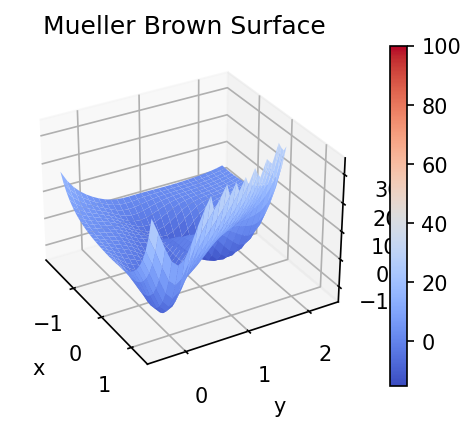

In [4]:
# This cell has problems in GoogleColab with the plt.figure line. CL/W
# Energy bar covers Z-axis label. CL

#%matplotlib widget 
#may need to change widget to inline for it to work on collab. CW
from mpl_toolkits.mplot3d import Axes3D
# from google.colab import output
# output.enable_custom_widget_manager()
import copy

fig = plt.figure(figsize=(6,3), dpi=150)
ax = fig.add_subplot(projection='3d')

# Made copy of Z just to clean up the plot.
# This removes extremely high energy points but lets us
# keep the shape of our Z array. CL
clean_Z = copy.copy(Z)
clean_Z[clean_Z>35] = np.nan

surf=ax.plot_surface(X, Y, clean_Z, rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, edgecolor='none', vmin=-15, vmax=100)

ax.view_init(30,-30)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title('Mueller Brown Surface')
plt.colorbar(surf)

plt.show()

**Contour surface**

Now we will create a contour surface plot of our training data. 

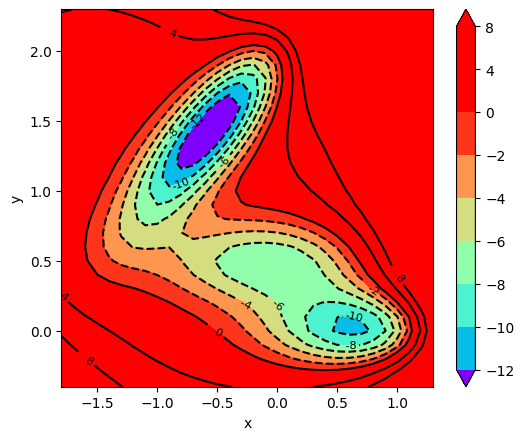

In [5]:
fig = plt.figure(figsize=(6,5), dpi=100)
levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
ct = plt.contour(X, Y, Z, levels, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()


**Loading PyTorch and training data**

After installing and importing pytorch, we will save our training data as a tensor data set. Why tensor data set? CL

In [6]:
#%pip install pytorch-lightning > /dev/null

import math
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

dataset = TensorDataset(Tensor(xy_truncated), Tensor(z_truncated))
train_loader = DataLoader(dataset, batch_size=32)
print("Size of training set:", len(train_loader.dataset))

Size of training set: 696


**A Basic Neural Network**

Below is a schematic of a neural netowrk. Inputs (x, y) are given weights (w) and biases (b) and are used as a value (v) for the activation function (tanh) at the input layer. The activation function decides the activity or contributions of each neuron in the input layer. Weights (w') and biases (b') are applied to the value (v') returned by the activation function and used to create the predicted value in the output layer ($V^{pred}$). 


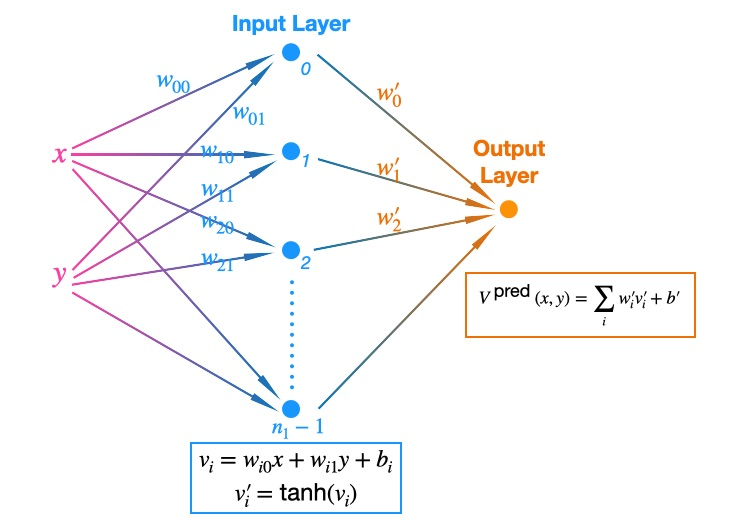

**The Neural Network Class**

Here we define our neural network as a python class. We also define a function to loop through our training data. 

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, n1=20):  #n1 is the number of neurons for the first layer
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,n1), # Linear function taking 2 inputs and outputs data for 20 neurons.
            nn.Tanh(),
            nn.Linear(n1, 1) # Linear function taking data from 20 neurons and producing one output value. 
        )

    def forward(self, x): 
        return self.model(x)

def train_loop(dataloader, model, optimizer, i_epoch):

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = F.mse_loss(pred.squeeze(), y)

        # Backpropagation - using the loss function gradients to update the weights and biases. CW
        optimizer.zero_grad() # Zero out the gradients to replace them. 
        loss.backward() # Update the gradients of the loss function.
        optimizer.step() # Uses step() to optimize the weights and biases with the updated gradients. 

        if batch % 15 == 0 and i_epoch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"epoch: {i_epoch:>3d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

**Training**

Now we can train the machine learning model. We will finish our training when the desired number of epochs has been reached. We will also define some terms used for training below.\
Epochs - Number of forward/backward passes through the entire neural network. \
Learning Rate - Determines the step size as we try to optimize the loss function. A faster learning rate would have a larger step size.\
Stochastic Gradient Descent (SGD) - The algorithm used for optimizing the loss function. 

In [8]:
# Training of Machine Learning Model

learning_rate = 1e-2
epochs = 1000
n1 = 20 
model = NeuralNetwork(n1)
loss_fn = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    train_loop(train_loader, model, optimizer, t)
    # prints: "epoch:", every 100 epochs, "loss:", error from the loss function, [   current position in traning set/ size of training set]
    # Note: In this example, there are 696 training points broken into 21 batches of batch size 32 (672 training points). 
    # That means there is an extra batch of 24 training points. When added together, this gives the full 696 training points. 
print("Done with Training!")

epoch:   0 loss:  28.965  [    0/  696]
epoch:   0 loss:  50.371  [  480/  696]
epoch: 100 loss:  19.747  [    0/  696]
epoch: 100 loss:  22.545  [  480/  696]
epoch: 200 loss:  17.315  [    0/  696]
epoch: 200 loss:  10.825  [  480/  696]
epoch: 300 loss:   4.793  [    0/  696]
epoch: 300 loss:   1.671  [  480/  696]
epoch: 400 loss:   2.635  [    0/  696]
epoch: 400 loss:   0.914  [  480/  696]
epoch: 500 loss:   2.378  [    0/  696]
epoch: 500 loss:   0.726  [  480/  696]
epoch: 600 loss:   1.971  [    0/  696]
epoch: 600 loss:   0.607  [  480/  696]
epoch: 700 loss:   1.406  [    0/  696]
epoch: 700 loss:   0.539  [  480/  696]
epoch: 800 loss:   0.961  [    0/  696]
epoch: 800 loss:   0.502  [  480/  696]
epoch: 900 loss:   0.746  [    0/  696]
epoch: 900 loss:   0.456  [  480/  696]
Done with Training!


**Plotting Predicted, Reference, and Difference Surfaces**

Finally, we will plot the Mueller-Brown potential energy surface using the neural network (predicted), using the analytical function (reference), and we will show the difference between the predicted and reference surfaces. 

diff, min, max: -1185.1995586304367 3.1187247969586602


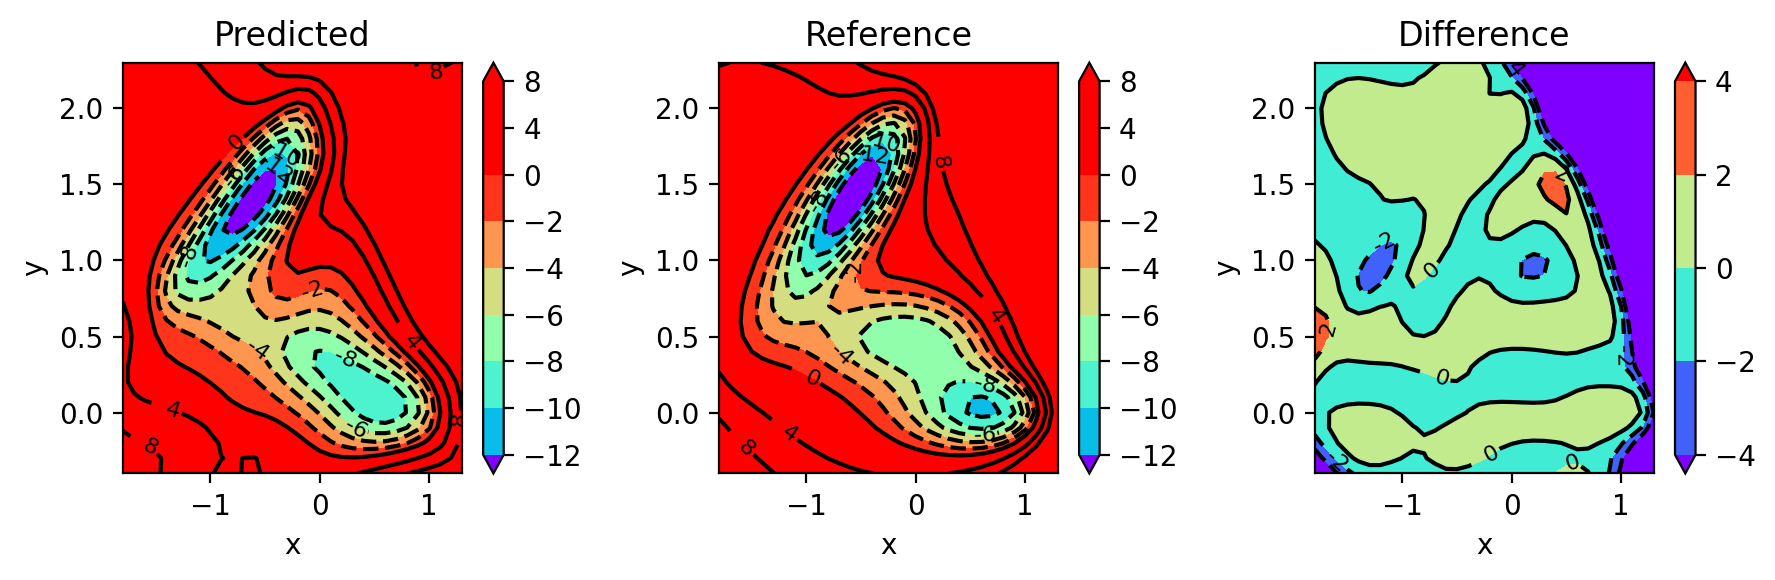

In [9]:
# Show the predicted surface, and compare to the reference one
def show_surface(model):

  z_pred = model(Tensor(xy))
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)

  fig = plt.figure(figsize=(9,3), dpi=200)

  plt.subplot(1, 3, 1)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(1, 3, 2)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(1, 3, 3)
  levels = [-4, -2, 0, 2, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend='both', vmin=-4, vmax=4)
  plt.title("Difference")
  plt.xlabel("x")
  plt.ylabel("y")
  print("diff, min, max:", np.amin(Zdiff), np.amax(Zdiff))
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_surface(model)

**Take a look at the NN parameters** 

In order to take a closer look at the neural network parameters, we can define the two linear functions and activation function for the neural network explicitly. 

In [10]:
print("model:", model)

for name, param in model.named_parameters():
    #print(name, param.data)
    if name == 'model.0.weight': weights0 = param.data.detach().numpy()
    elif name == 'model.0.bias': bias0 = param.data.detach().numpy()
    elif name == 'model.2.weight': weights2 = param.data.detach().numpy()
    elif name == 'model.2.bias': bias2 = param.data.detach().numpy()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

#print("weights2:", weights2)
#print("bias2:", bias2)

#first linear function
v1 = np.zeros(n1)
for i in range(0, n1):
  v1[i] += weights0[i,0] * xy0[0] + weights0[i,1] * xy0[1] + bias0[i]

#activation function
v2 = np.zeros(n1)
for i in range(0, n1):
  v2[i] = tanh(v1[i])

#second linear function
z_pred = 0.0
for i in range(0, n1):
  z_pred += weights2[0,i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

#print(model[0].weight)

model: NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
z0: tensor([-13.2187], grad_fn=<AddBackward0>) z_pred: -13.218699569984164


In [11]:
#Do we need this? CL

print("model:", model)

# Ordered dictionary with all parameters (Linear 1, Activation, and Linear 2)
params = model.state_dict()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

# First Linear Function
v1 = np.zeros(n1)
for i in range(n1):
  v1[i] = params['model.0.weight'][i][0]*xy0[0] + params['model.0.weight'][i][1]*xy0[1] + params['model.0.bias'][i]

# Activation Function
v2 = np.zeros(n1)
for i in range(n1):
  v2[i] = tanh(v1[i])

# Second Linear Function
z_pred = 0.0
for i in range(n1):
  z_pred += params['model.2.weight'][0,i] * v2[i]
z_pred += params['model.2.bias'][0]

print("z0:", z0, "\nz_pred:", z_pred)

model: NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
z0: tensor([-13.2187], grad_fn=<AddBackward0>) 
z_pred: tensor(-13.2187)


**A more automated/refined implementation**

Below is a more professional implementation of the neural network that saves epoch infromation in the logs_csv/ directory. 

In [12]:
class pl_model(pl.LightningModule):
    def __init__(self, n1=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,n1),
            nn.Tanh(),
            nn.Linear(n1, 1)
        )
        self.learning_rate = 1e-2

    def forward(self, x): 
        return self.model(x)

    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        loss = F.mse_loss(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        # Using the Adam optimzation algorithm instead of SGD. 
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 1,
                    }
        return [optimizer]#, [scheduler]

csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=1000, logger=csv_logger)
n1 = 20
model = pl_model(n1)
trainer.fit(model, train_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81    
-------------------------------------
81        Trainable params
0         Non-trainable params
81        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  18%|█▊        | 4/22 [00:00<00:00, 98.89it/s, loss=21.7, v_num=1] 

/Applications/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Applications/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 144.32it/s, loss=1.11, v_num=1] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 139.04it/s, loss=1.11, v_num=1]


**Plotting Training Error**

Now we can plot the training error as the number of epochs increases. 

Text(0, 0.5, 'Training Errors')

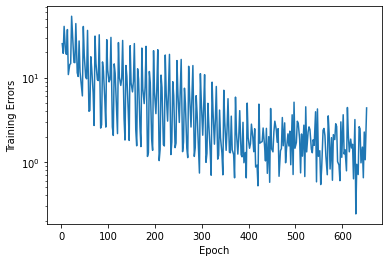

In [13]:
import pandas as pd
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")

fig, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Errors")


**Plot of the Predicted, Reference, and Difference Surfaces**

Again, we plot the predicted, reference, and difference surfaces using the more refined neural network implementation. 

diff, min, max: -1162.2833284287155 2.751551869913081


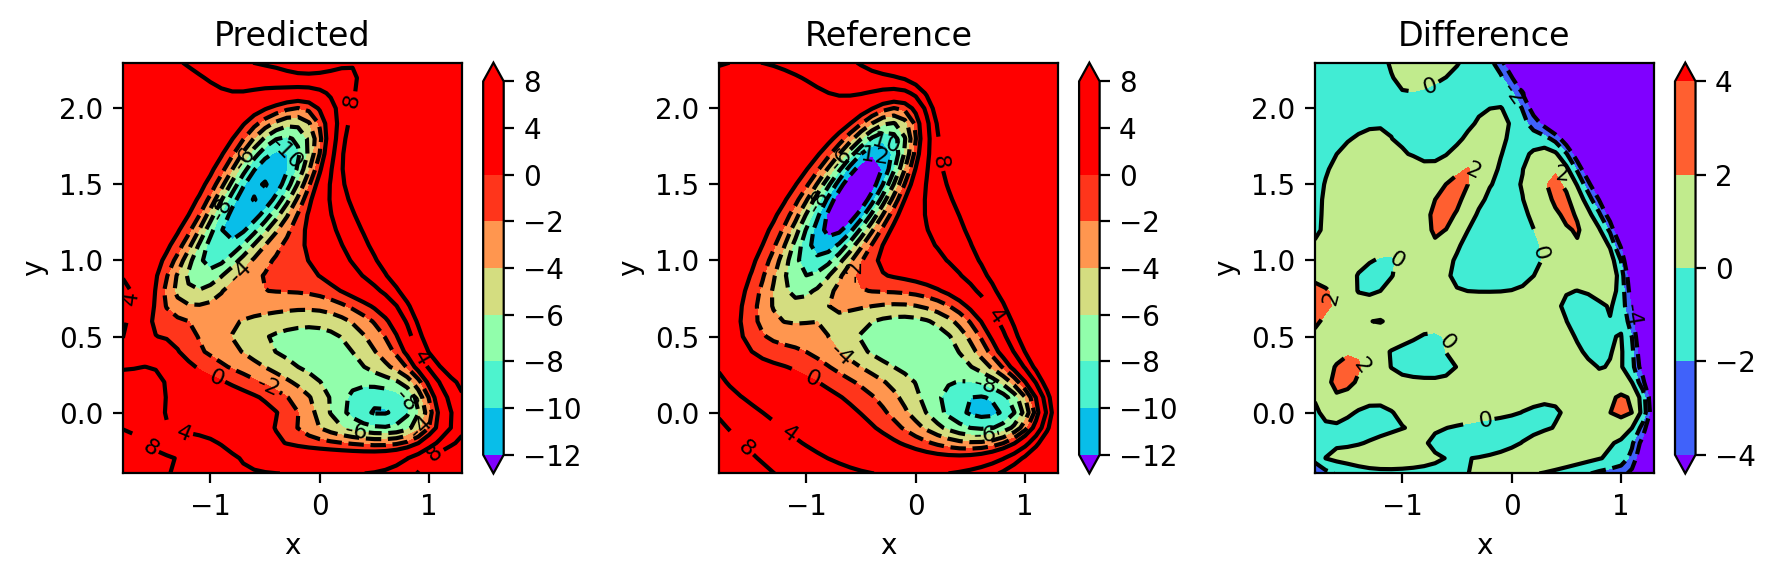

In [14]:
show_surface(model)